In [1]:
import os
from dotenv import load_dotenv
load_dotenv(dotenv_path=os.path.join('studio', '.env'))

True

In [2]:
from langchain_openai import ChatOpenAI

# Prompts we will use
subjects_prompt = """Generate a list of 3 planets that are all related to this overall topic: {topic}."""
fact_prompt = """Generate an interesting scientific fact about {subject}"""
best_fact_prompt = """Below are a bunch of facts about {topic}. Select the most interesting one! Return the ID of the most interesting one, starting 0 as the ID for the first fact. Facts: \n\n  {facts}"""

# LLM
model = ChatOpenAI(model="gpt-4o", temperature=0)

In [3]:
import operator
from typing import Annotated
from typing_extensions import TypedDict
from pydantic import BaseModel

class Subjects(BaseModel):
    subjects: list[str]

class BestFact(BaseModel):
    id: int
    
class OverallState(TypedDict):
    topic: str
    subjects: list
    facts: Annotated[list, operator.add]
    best_selected_fact: str

In [4]:
def generate_topics(state: OverallState):
    prompt = subjects_prompt.format(topic=state["topic"])
    response = model.with_structured_output(Subjects).invoke(prompt)
    return {"subjects": response.subjects}

In [5]:
from langgraph.types import Send
def continue_to_facts(state: OverallState):
    return [Send("generate_fact", {"subject": s}) for s in state["subjects"]]

In [6]:
class FactState(TypedDict):
    subject: str

class Fact(BaseModel):
    fact: str

def generate_fact(state: FactState):
    prompt = fact_prompt.format(subject=state["subject"])
    response = model.with_structured_output(Fact).invoke(prompt)
    return {"facts": [response.fact]}

In [7]:
def best_fact(state: OverallState):
    facts = "\n\n".join(state["facts"])
    prompt = best_fact_prompt.format(topic=state["topic"], facts=facts)
    response = model.with_structured_output(BestFact).invoke(prompt)
    return {"best_selected_fact": state["facts"][response.id]}

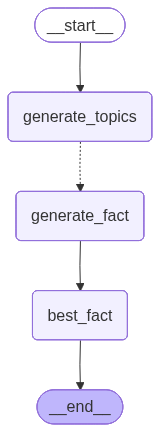

In [8]:
from IPython.display import Image
from langgraph.graph import END, StateGraph, START

# Construct the graph: here we put everything together to construct our graph
graph = StateGraph(OverallState)
graph.add_node("generate_topics", generate_topics)
graph.add_node("generate_fact", generate_fact)
graph.add_node("best_fact", best_fact)
graph.add_edge(START, "generate_topics")
graph.add_conditional_edges("generate_topics", continue_to_facts, ["generate_fact"])
graph.add_edge("generate_fact", "best_fact")
graph.add_edge("best_fact", END)

# Compile the graph
app = graph.compile()
Image(app.get_graph().draw_mermaid_png())

In [9]:
# Call the graph: here we call it to generate a list of jokes
for s in app.stream({"topic": "solar system planets"}):
    print(s)

{'generate_topics': {'subjects': ['Mars', 'Jupiter', 'Neptune']}}
{'generate_fact': {'facts': ["Jupiter, the largest planet in our solar system, is so massive that it doesn't orbit the Sun in the same way other planets do. Instead, it orbits a point in space just outside the Sun's surface, known as the barycenter. This is because Jupiter's mass is so significant that the center of mass between it and the Sun lies outside the Sun itself. This unique orbital characteristic highlights Jupiter's immense gravitational influence in our solar system."]}}
{'generate_fact': {'facts': ['Mars, often referred to as the "Red Planet," has the largest volcano in the solar system, Olympus Mons. This colossal shield volcano stands about 13.6 miles (22 kilometers) high, which is nearly three times the height of Mount Everest, Earth\'s tallest mountain above sea level. Olympus Mons spans approximately 370 miles (600 kilometers) in diameter, making it roughly the size of the state of Arizona. Its massive 